<a href="https://colab.research.google.com/github/Krankile/eikon-wrapper/blob/main/data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%%capture
!pip install eikon
!pip install wandb

In [ ]:
import eikon as ek
import wandb
import pandas as pd
import numpy as np
import time
import os
import glob
from tqdm.auto import tqdm


In [ ]:
#"api_key_lk"
ek.set_app_key("example")

## Screen companies

In [ ]:
mic_exchanges = pd.read_csv("mic_codes.csv").set_index("MIC") #Can be used to look up specific stock exchanges codes :) (Y) 

In [ ]:
oil_osebx_screen = 'SCREEN(U(IN(Equity(active,public,primary))), TR.CompanyMarketCap>=500000, IN(TR.ExchangeMarketIdCode,"XOSL"), IN(TR.TRBCBusinessSectorCode,"5010","5020","5030"), CURN=USD)'
fields_oil_osebx_screen = ["TR.CommonName"]#["TR.CommonName","TR.CompanyMarketCap","TR.ExchangeName","TR.TRBCBusinessSector","TR.TotalReturn3Mo"]

osbx_companies, e = ek.get_data(oil_osebx_screen, fields_oil_osebx_screen)
osbx_companies = osbx_companies.set_index("Instrument")

In [ ]:
oil_global_screen = 'SCREEN(U(IN(Equity(active,public,primary))), TR.CompanyMarketCap>=500000, IN(TR.TRBCBusinessSectorCode,"5010","5020","5030"), CURN=USD)'
fields_oil_global_screen = ["TR.CommonName"]

global_oil, e = ek.get_data(oil_global_screen, fields_oil_global_screen)
global_oil = global_oil.set_index("Instrument")


In [ ]:
financial_global_screen = 'SCREEN(U(IN(Equity(active,public,primary))), TR.CompanyMarketCap>=500000, IN(TR.TRBCBusinessSectorCode,"5510"), CURN=USD)'
fields_financial_global_screen = ["TR.CommonName"]

global_financial, e = ek.get_data(financial_global_screen, fields_financial_global_screen)
global_financial = global_financial.set_index("Instrument")

Now we have dataframe of all noted oil companies (with mcap > USD 5m) in eikon refinitives entire database

# Collect data from eikon refinitiv

In [ ]:
######## INPUTS ########
lst_of_tickers = global_financial.index.to_list()

#Eikon parameters
start_date = '2000-01-01'
end_date = '2022-04-21'
ek_params = {'SDate': start_date, 'EDate': end_date,'Frq': 'FQ', "Curn":"USD", 'period':"FQ0"}

#Max http company request at once
search_limit = 1

#What data to get
get_stock_data = False
get_meta_data = False
get_fundamental_data = True 
get_broker_data = False

toggle_dict = {'stock_data':get_stock_data, 'meta_data':get_meta_data,
               'fundamental_data':get_fundamental_data, 'broker_data':get_broker_data}



params = ek_params | toggle_dict | {'limit': search_limit} 
########################

## We define functions to find stock, meta, fundamental and broker estimates data 

In [ ]:
def _sub_lists(data, size_m):
    return [data[x:x+size_m] for x in range(0, len(data), size_m)]

#Function to counteract http timeout
def _divide_pull_request(lst_of_tickers, fields, params, suffix):

    p = {key: val for key, val in params.items() if key in ek_params}    
    if len(lst_of_tickers) > params['limit']:
        dfs = []
        for sub_ticker_lst in tqdm(_sub_lists(lst_of_tickers, params['limit']), suffix):
            df_sub, err = ek.get_data(lst_of_tickers, fields, p)
            print(df_sub)
            dfs.append(df_sub)
        df = pd.concat(dfs, axis=0)
    else: 
        df, err = ek.get_data(lst_of_tickers, fields, p)
    return df

In [ ]:
def stock_data(lst_of_tickers, params):
    
    params_new = params.copy()
    params_new['Frq'] = 'D'
    
    fields = ['TR.CompanyMarketCap.Date','TR.CompanyMarketCap', 'TR.PriceClose',
              'TR.CompanyMarketCap.Currency'] #TR.F.ComShrOutsTot
    
    stock_df = _divide_pull_request(lst_of_tickers, fields=fields, params=params_new, suffix=' Getting time series')
    
    return stock_df

In [ ]:
#Meta data collector
def meta_data(lst_of_tickers):
    geography = ['TR.ExchangeMarketIdCode', 'TR.HeadquartersRegionAlt', 'TR.HeadquartersCountry', 'TR.HQStateProvince']
    sectors = ['TR.TRBCEconomicSector', 'TR.TRBCBusinessSector', 'TR.TRBCIndustryGroup', 'TR.TRBCIndustry', 'TR.TRBCActivity']
    founded = ['TR.OrgFoundedYear']

    meta_data = geography + founded + sectors  
    meta_df, _ = ek.get_data(lst_of_tickers, meta_data)
    meta_df = meta_df.set_index("Instrument")
    
    meta_df['Organization Founded Year'] = meta_df['Organization Founded Year'].replace(0, np.NaN) #<-- Eikon hilariously uses 0 instead of Na for missing year value
    
    
    return meta_df

In [ ]:
#Fundamental data collector

def fundamental_data(lst_of_tickers, params):
    #fields    
    profits = ['TR.TotalRevenue', 'TR.GrossProfit','TR.EBITDA','TR.EBIT', 'TR.F.NetIncAfterTax']#, 'TR.EV','MKT_CAP']
    balance = ['TR.F.TotAssets','TR.F.TotCurrAssets','TR.F.TotLiab','TR.F.TotCurrLiab','TR.F.LTDebtPctofTotAssets','TR.F.STDebtPctofTotAssets',"TR.InvtrPriceToBook"]#TR.F.TotLiab(Period=FY0)
    cash_flow = ['TR.F.LeveredFOCF']
    fundamental_data = profits + balance + cash_flow 
    
    other = []#['TR.InsiderBuyDepthComp'] <--- NA only, could be interesting to use....   
    reported_dates = ['TR.TotalRevenue.date','TR.TotalRevenue.periodenddate','TR.BSOriginalAnnouncementDate']
    
    fields = reported_dates + fundamental_data + other
    
    #collect data
    fundamental_df = _divide_pull_request(lst_of_tickers, fields, params, suffix=' Getting fundamentals')
    
    return fundamental_df

In [ ]:
def broker_estimates(lst_of_tickers, params):
    
    params_new = params.copy()
    params_new["Period"] = "FY1"    
    
    fields = ["TR.EPSMean","TR.EPSMean.periodenddate","TR.EBITMean",'TR.RevenueMean',
              "TR.ROAMean","TR.ROEMean","TR.FCFMean","TR.TotalAssets","TR.MeanPctChg(Period=FY1,WP=60d)"]
    
    estimates_df, err = ek.get_data(lst_of_tickers, fields, params)
    return estimates_df

In [ ]:
def get_data(lst_of_tickers, params):
    
    stock_df = None
    meta_df = None
    fundamental_df = None
    broker_df = None
    
    if params['stock_data']: 
        stock_df = stock_data(lst_of_tickers, params)

    if params['meta_data']:
        meta_df = meta_data(lst_of_tickers)

    if params['fundamental_data']:
        fundamental_df = fundamental_data(lst_of_tickers, params)

    if params['broker_data']:
        broker_df = broker_estiqates(lst_of_tickers, params)
    
    return stock_df, meta_df, fundamental_df, broker_df
        

In [ ]:
def save_data(file_name, save_per_n_http_request, lst_of_tickers, params):
    
    non_collected_tickers = []

    name_to_index = {}
    dfs = {}
    for i, possible_key in enumerate(["stock_data", "meta_data", "fundamental_data", "broker_data"]):
        if params[possible_key]:
            name_to_index[possible_key] = i
            dfs[possible_key] = []
    
    partioned_lst_of_tickers = _sub_lists(lst_of_tickers, params["limit"])        
    for i, sub_ticker_lst in enumerate(tqdm(partioned_lst_of_tickers, "saving loop")):    
        
        try:
            raw_data_dfs = get_data(sub_ticker_lst, params)
            
            for key in name_to_index:
           
                dfs[key] = dfs[key] + [raw_data_dfs[name_to_index[key]]]
                
                
                
            if not (i % save_per_n_http_request):
                for key in name_to_index:
                    df = pd.concat(dfs[key], axis=0)
                    df = df.reset_index()
                    
                    df.to_feather(f"{file_name}_save={i}_type={key}.feather")
                    
                    
                    dfs[key] = []

        except ek.EikonError as err:
            for key in name_to_index:
                dfs[key] = []
                
            non_collected_tickers += sub_ticker_lst
        except Exception as e:
            print(e)
            for key in name_to_index:
                dfs[key] = []
                
            non_collected_tickers += sub_ticker_lst
            
    #Write crashes to file       
    with open(f"{file_name}.txt", "w") as f:
        f.write("\n".join(non_collected_tickers))
    
    #Save last data if there are rests
    for key in name_to_index:
            break
            if dfs[key] != []:
                df = pd.concat(dfs[key], axis=0)

                df = df.reset_index()

                #wtfffff
                df.to_feather(f"{file_name}_save={len(partioned_lst_of_tickers)}_type={key}.feather")

            

In [ ]:
def _time_interval(start_date, end_date):
    y0 = int(start_date.split("-")[0])
    yn = int(end_date.split("-")[0])
    in_between_dates = [f"{str(year)}-01-01" for year in range(y0+1,yn,7)]
    return [start_date] + in_between_dates  + [end_date]
    
        
#This is code for getting macro timeseries data, as Refinitivs get_data method was hard to work with. 
def macro_data(lst_of_tickers, ek_get_timeseries_fields, params):
        start_and_ends = _time_interval(params["SDate"],params["EDate"])
        
        tickers_to_serie = {}
        for ticker in lst_of_tickers:
            tickers_to_serie[ticker] = []
            for i in range(len(start_and_ends)-1):
                try: 
                    time_series = ek.get_timeseries(ticker, fields=ek_get_timeseries_fields,
                                                    start_date=start_and_ends[i], end_date=start_and_ends[i+1], interval=params["interval"])
                                 
                except ek.EikonError as err:
                    if err.code ==-1:
                        time_series = ek.get_timeseries("BRT-", fields=ek_get_timeseries_fields, start_date=start_and_ends[i], end_date=start_and_ends[i+1],interval=params["interval"])
                        time_series[ek_get_timeseries_fields] = np.nan
                        
                    if err.code ==  2504:
                        print("backend error")
                        time.sleep(2)
                        time_series = ek.get_timeseries(ticker, fields=ek_get_timeseries_fields,
                                                    start_date=start_and_ends[i], end_date=start_and_ends[i+1], interval=params["interval"])
                        
                tickers_to_serie[ticker] = tickers_to_serie[ticker] + [time_series]
            
            tickers_to_serie[ticker] = pd.concat(tickers_to_serie[ticker], axis=0)
            
        return tickers_to_serie

In [ ]:
_, meta_df, __, ___ = get_data(lst_of_tickers, params)

In [ ]:
meta_df["TRBC Industry Group Name"].to_list()

['Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Investment Banking & Investment Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Banking Services',
 'Investment Banking & Investment Services',
 'Investment Banking & Investment Services',
 'Ba

In [ ]:
banking_df = meta_df[(meta_df["TRBC Industry Group Name"] == "Banking Services") | (meta_df["TRBC Industry Group Name"] == "Insurance")] 

In [ ]:
tickers = pd.read_fwf("C:/Users/kjartkra/Untitled Folder/banking_fundamental_data/banking_fundamental_data.txt")

,FMNB.OQ
0,FBAK.PK
1,SPOG.OL
2,DNB.OL
3,EGBE.CA
4,MORGS.OL
...,...
2201,7384.T
2202,JCFN.TA
2203,BNCOM.PS
2204,BHI.CN


In [ ]:
lst_of_tickers = banking_df.index.to_list()
save_toggle = True

file_name = "C:/Users/kjartkra/Untitled Folder/banking_fundamental_data/banking_fundamental_data_2"
if save_toggle: 
    save_data(file_name, 1, lst_of_tickers, params)

saving loop:   0%|          | 0/2657 [00:00<?, ?it/s]

2022-05-19 11:01:24,973 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 11:01:24,973 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 11:21:16,429 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 11:21:16,429 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 11:29:08,643 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 11:29:08,644 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 11:30:05,207 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 11:30:05,207 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 12:02:25,181 P[9944] [MainThread 7108] HTTP TimeoutException: .


feather must have string column names


2022-05-19 13:01:19,217 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:01:19,218 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 13:01:43,933 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:01:43,934 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request


feather must have string column names


2022-05-19 13:09:46,547 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:09:46,548 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 13:10:07,275 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:10:07,275 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request


feather must have string column names


2022-05-19 13:22:44,368 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:22:44,369 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 13:23:02,707 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:23:02,707 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 13:23:24,361 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:23:24,361 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 13:25:04,096 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:25:04,097 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request
2022-05-19 13:25:23,520 P[9944] [MainThread 7108] Backend error. 400 Bad Request
2022-05-19 13:25:23,521 P[9944] [MainThread 7108] HTTP request failed: EikonError-Backend error. 400 Bad Request


feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names
feather must have string column names


In [ ]:
get_macro_toggle = True

if get_macro_toggle:
    macro_oil_params = ek_params.copy()
    macro_oil_params["interval"] = "daily"
    macro_oil_series = ["BRT-", "CLc1", "CLc12", "CLc60", "WTCLc1", "WTCLc12", "WTCLc60","NGMMc1", "NGMMc12", "NGMMc60", "LNG-AS", "TR-PETTHP-LNG", "WTI-USG-REF", "DUB-SIN-REF"]
    macro_banking_series = ["SHIBOR=", "CN10YT=RR", "USDSOFR=", "US10YT=RR", "EURIBOR01", "DE10YT=RR","GB10YT=RR"] #china 10 year treasury yield, USA 10 year 
    general_series = ["JNK", ".VIX",'EUR=', 'GBP=', "CNY="] #High yield bond, unemployment
    
    macro_oil_series_not_added = ["TRGBNBPD1"]
    macro_oil_fields = ["CLOSE"]

    macro_oil = macro_data(macro_oil_series + macro_banking_series + general_series, macro_oil_fields , macro_oil_params)

2022-05-19 15:07:37,745 P[9944] [MainThread 7108] Error with CLc60: No data available for the requested date range
2022-05-19 15:07:37,745 P[9944] [MainThread 7108] CLc60: No data available for the requested date range | 
2022-05-19 15:07:39,555 P[9944] [MainThread 7108] Error with WTCLc1: No data available for the requested date range
2022-05-19 15:07:39,556 P[9944] [MainThread 7108] WTCLc1: No data available for the requested date range | 
2022-05-19 15:07:43,855 P[9944] [MainThread 7108] Error with WTCLc12: No data available for the requested date range
2022-05-19 15:07:43,855 P[9944] [MainThread 7108] WTCLc12: No data available for the requested date range | 
2022-05-19 15:07:47,642 P[9944] [MainThread 7108] Error with WTCLc60: No data available for the requested date range
2022-05-19 15:07:47,642 P[9944] [MainThread 7108] WTCLc60: No data available for the requested date range | 
2022-05-19 15:07:54,054 P[9944] [MainThread 7108] Error with NGMMc1: No data available for the request

In [ ]:
macro_oil

{'BRT-': BRT-         CLOSE
 Date              
 2000-01-04    24.4
 2000-01-05   23.65
 2000-01-06   23.54
 2000-01-07   22.95
 2000-01-10    22.8
 ...            ...
 2022-04-13  107.39
 2022-04-14   108.0
 2022-04-19  105.67
 2022-04-20  104.78
 2022-04-21  106.51
 
 [5635 rows x 1 columns],
 'CLc1': CLc1         CLOSE
 Date              
 2000-01-04   25.55
 2000-01-05   24.91
 2000-01-06   24.78
 2000-01-07   24.22
 2000-01-10   24.67
 ...            ...
 2022-04-14  106.95
 2022-04-18  108.21
 2022-04-19  102.56
 2022-04-20  102.75
 2022-04-21  103.79
 
 [5605 rows x 1 columns],
 'CLc12': CLc12       CLOSE
 Date             
 2000-01-04  20.24
 2000-01-05  19.92
 2000-01-06  19.85
 2000-01-07  19.95
 2000-01-10   20.3
 ...           ...
 2022-04-14   93.6
 2022-04-18   93.4
 2022-04-19  89.08
 2022-04-20  89.69
 2022-04-21  90.13
 
 [5602 rows x 1 columns],
 'CLc60':             CLOSE
 Date             
 2000-01-04   <NA>
 2000-01-05   <NA>
 2000-01-06   <NA>
 2000-01-07   <NA>
 

## Define some file handling functions

In [ ]:
def dict_to_df(dictionary):
    dates = set()

    for key, frame in dictionary.items():
        dates |= set(frame.index.values)
    
    index = pd.Index(list(sorted(dates)))
    
    all_macro = pd.DataFrame(index=index)

    for key, frame in dictionary.items():
        frame = frame[~frame.index.duplicated(keep='first')]
        all_macro[key] = frame

    return all_macro

In [ ]:
def folder_to_df(folder_with_data):
    files = glob.glob(folder_with_data + '/*.feather')
    dfs = []
    for file in files:
        dfs.append(pd.read_feather(file).set_index("index"))

    df_big = pd.concat(dfs, axis=0).reset_index()
    df_big = df_big.drop("index", axis=1)
    return df_big

In [ ]:
def upload_artifact(run, dataframe_file_location, artifact_name):
    
    artifact = wandb.Artifact(artifact_name, type='dataset')

    # Add a file to the artifact's contents
    artifact.add_file(dataframe_file_location)

    # Save the artifact version to W&B and mark it as the output of this run
    run.log_artifact(artifact)

In [ ]:
macro_df.reset_index().to_feather('C:/Users/kjartkra/Untitled Folder/macro_df.feather')

## Collect data from folder generated by save functions to a feather file

In [ ]:
collect_meta_data = False
if collect_meta_data:
    stock_df, meta_df, fundamental_df, broker_df = get_data(lst_of_tickers, params)

    meta_location = 'C:/Users/kjartkra/Untitled Folder/meta_oil.feather'
    meta_df.reset_index().to_feather(meta_location)

In [ ]:
collect_fundamental_data = True
fundamentals_location = 'C:/Users/kjartkra/Untitled Folder/fundamentals_banking.feather'

if collect_fundamental_data:
    fundamentals_df = folder_to_df("C:/Users/kjartkra/Untitled Folder/banking_fundamental_data/")
    fundamentals_df.drop_duplicates()

    fundamentals_df.to_feather(fundamentals_location)

In [ ]:
stock_data = pd.read_feather("C:/Users/kjartkra/Untitled Folder/stock_banking.feather")
fundamental_data = pd.read_feather('C:/Users/kjartkra/Untitled Folder/fundamentals_banking.feather')



In [ ]:
fundamental_data.Instrument.unique()

<StringArray>
[ 'KAER.VI',   'PBF.WA',   'OXF2.L',  'NWYF.PK',  'RVSB.OQ',  'UCRE.BO',
  'BSPA.PK',  'SOME.PK',   'LAW.AX',  'FBVI.PK',
 ...
  'CFFI.OQ',  'MDVT.PK',  'VBFC.OQ',  'MOFG.OQ',  'KBNK.NS',  'CRDI.MI',
   '8359.T',  'CIEB.CA',  'AMMB.KL', 'QNBFL.IS']
Length: 2625, dtype: string

In [ ]:

stock_data.reset_index().to_feather("C:/Users/kjartkra/Untitled Folder/stock_banking_v2.feather")

In [ ]:
collect_macro_data = False
macro_location = 'C:/Users/kjartkra/Untitled Folder/macro_oil.feather'

if collect_macro_data:
    macro_df = dict_to_df(macro_oil).reset_index()
    
    macro_df.to_feather(macro_location)

In [ ]:
collect_stock_data = True
company_location = 'C:/Users/kjartkra/Untitled Folder/stock_banking.feather'

if collect_stock_data:
    oil_company_df = folder_to_df("C:/Users/kjartkra/Untitled Folder/banking_stock_data/")

  

    oil_company_df.to_feather(company_location)


In [ ]:
fundamental_oil = pd.concat([fundamental_oil_1,fundamental_oil_2], axis=0)

In [ ]:
fundamental_oil.reset_index().to_feather(fundamentals_location)

In [ ]:
meta_df[meta_df.index.isin(fundamental_data.Instrument.unique())].reset_index().to_feather("C:/Users/kjartkra/Untitled Folder/meta_banking.feather")

## Upload feather files to wandb 

In [ ]:
upload_stocks = False
upload_meta = False
upload_fundamentals = False
upload_macro = True

sector_type = "banking"

stock_location = "C:/Users/kjartkra/Untitled Folder/stock_banking_v2.feather"
fundamentals_location = 'C:/Users/kjartkra/Untitled Folder/fundamentals_banking.feather'
meta_location = "C:/Users/kjartkra/Untitled Folder/meta_banking.feather"
macro_location = 'C:/Users/kjartkra/Untitled Folder/macro_df.feather'
if  upload_stocks or upload_meta or upload_fundamentals or upload_macro:
    with wandb.init(project="master-test") as run:
        
        if upload_stocks:
            upload_artifact(run, company_location, f"{sector_type}-company-data")
        
        if upload_meta: 
            upload_artifact(run, meta_location, f"{sector_type}-meta-data")
        
        if upload_fundamentals:
            upload_artifact(run, fundamentals_location, f"{sector_type}-fundamental-data")
        
        if upload_macro:
            upload_artifact(run, macro_location, "macro-data")
      

## Testing

In [ ]:
fundamental_df = pd.read_feather(fundamentals_location)

In [ ]:
for ticker in fundamental_df.columns[5:9]:

    fundamental_df[f"{ticker}p"] = fundamental_df[ticker] / fundamental_df["Total Revenue"]

In [ ]:
import matplotlib.pyplot as plt

def get_list_of_data_field(fundamental_df, field):
    metric_list = []
    unique_companies = list(set(fundamentals_df["Instrument"].to_list()))
    
    for ticker in unique_companies:
        metric_1_comp = fundamentals_df[fundamentals_df["Instrument"] == ticker][field].fillna(-1).to_list()
        if len(metric_1_comp) < 100: 
            metric_list.append(np.array(metric_1_comp))
    return metric_list

In [ ]:
def print_all(lst, type_toggle, log_toggle):
    if log_toggle:
        plt.yscale('log')
    if type_toggle == "scatter":
        for series in lst:
            plt.scatter([x for x in range(len(series))], series)
    else:
        for series in lst:
            plt.plot([x for x in range(len(series))], series)

In [ ]:
EBITDAp = get_list_of_data_field(fundamental_df, "EBITDAp")

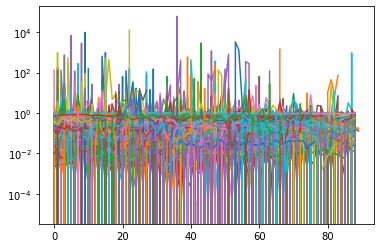

In [ ]:
print_all(EBITDAp, None, log_toggle=True)

In [ ]:
revenue_list = get_list_of_data_field(fundamental_df, "Total Revenue")
ebit_list = get_list_of_data_field(fundamental_df, "EBIT")

In [ ]:
margin_lists = []

for i in range(len(revenue_list)):
    margin_lists.append(ebit_list[i]/revenue_list[i])

C:\Users\kjartkra\AppData\Local\Temp/ipykernel_4972/2902622931.py:4: RuntimeWarning: divide by zero encountered in true_divide
  margin_lists.append(ebit_list[i]/revenue_list[i])
C:\Users\kjartkra\AppData\Local\Temp/ipykernel_4972/2902622931.py:4: RuntimeWarning: invalid value encountered in true_divide
  margin_lists.append(ebit_list[i]/revenue_list[i])


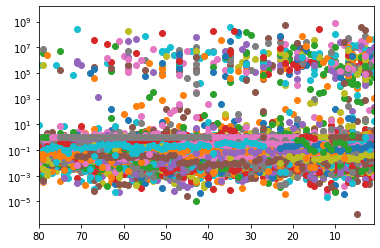

In [ ]:
plt.xlim(80)
print_all(margin_lists, "scatter", log_toggle=True)
#print_all(ebit_list, "scatter", log_toggle=True)

In [ ]:
_max = -1
max_lst = None
for lst in ebit_list:
    if len(lst) > _max:
        _max = len(lst)
        max_lst = lst

In [ ]:
df_big

In [ ]:
wandb.init()

artifact = wandb.Artifact('mnist', type='dataset')
artifact.add_dir('mnist/')
wandb.log_artifact(artifact)

In [ ]:
time_series_df_2, meta_df, fundamental_df, broker_df = get_data(lst_of_tickers[:5], params)
time_series_df_2

In [ ]:
time_series_df_2["Number Of Stocks"].isna().sum()

In [ ]:
time_series_df["Common Shares - Outstanding - Total"].isna().sum()

In [ ]:
time_series_df

In [ ]:
pd.set_option('display.max_rows', 1000)
time_series_df.to_excel("stock_data_2.xlsx")

In [ ]:
#Conclusion, makes small difference in time to process at server
test_time = False

if test_time: 
    params_single = {'SDate': start_date, 'EDate': end_date,'Frq': 'FQ','Period': 'FQ0'}
    params_curn = {'SDate': start_date, 'EDate': end_date,'Frq': 'FQ','Period': 'FQ0', "Curn":"USD"}
    
    
    start_time = time.time()
    data,err = ek.get_data(osbx_companies.index[:3].to_list(), financials, params_single)
    print("--- simple: %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    data_usd,err = ek.get_data(osbx_companies.index[:3].to_list(), financials, params_curn)
    print("--- Curn: %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    data_all,err = ek.get_data(osbx_companies.index[:3].to_list(), financials, params)
    print("--- Scale & Curn: %s seconds ---" % (time.time() - start_time))